In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import raw_data_processing
import tensorflow as tf
import pickle
import self_har_models
import numpy as np
import data_pre_processing
import seaborn as sns
tf.get_logger().setLevel('INFO')

In [2]:
with open('pickled_datasets/harth.pickle', 'rb') as file:
    harth_df = pickle.load(file)

In [3]:
full_model = tf.keras.models.load_model('CNN-LSTM')

In [4]:
core_model = self_har_models.extract_core_model(full_model)

In [5]:
core_model.summary()

Model: "CNN-LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 400, 3)]          0         
                                                                 
 dense (Dense)               (None, 400, 300)          1200      
                                                                 
 conv1d (Conv1D)             (None, 398, 64)           57664     
                                                                 
 conv1d_1 (Conv1D)           (None, 396, 128)          24704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 197, 128)         0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 97, 128)           82048     
                                                          

In [6]:
def get_labels(data):
    all_labels = []
    for user in data:
        all_labels = np.concatenate((np.unique(data[user][0][1]), all_labels))
    labels = np.unique(all_labels)
    return labels

labels = get_labels(harth_df)
label_map = {label: index for index, label in enumerate(labels)}
print(label_map)

{'cycling (sit)': 0, 'cycling (sit, inactive)': 1, 'cycling (stand)': 2, 'cycling (stand, inactive)': 3, 'lying': 4, 'running': 5, 'shuffling': 6, 'sitting': 7, 'stairs (ascending)': 8, 'stairs (descending)': 9, 'standing': 10, 'walking': 11}


In [7]:
user_datasets_processed = data_pre_processing.pre_process_dataset_composite(
harth_df, label_map, 12,
    ['006', '008', '009', '010', '012', '013' , '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025'],
['026', '027', '028', '029'], 400, 200)

getting mean
[-0.87959782 -0.00604676 -0.14753301]
[0.33156394 0.23069429 0.35753116]
normalising train set
normalisnig test


In [8]:
callback = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

In [9]:
full_CNNLSTM_model = self_har_models.attach_full_har_classification_head(core_model, 12, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))
CNNLSTM_history = full_CNNLSTM_model.fit(user_datasets_processed[0][0], user_datasets_processed[0][1]
                    , epochs=100, validation_data=(user_datasets_processed[1][0], user_datasets_processed[1][1]), callbacks=[callback])

Epoch 1/100
720/720 [==============================] - 12s 12ms/step - loss: 0.7574 - categorical_accuracy: 0.7622 - auc: 0.9740 - precision: 0.8068 - recall: 0.6991 - val_loss: 0.6186 - val_categorical_accuracy: 0.7882 - val_auc: 0.9819 - val_precision: 0.8143 - val_recall: 0.7599
Epoch 2/100
720/720 [==============================] - 7s 9ms/step - loss: 0.5581 - categorical_accuracy: 0.8051 - auc: 0.9850 - precision: 0.8309 - recall: 0.7787 - val_loss: 0.4896 - val_categorical_accuracy: 0.8286 - val_auc: 0.9889 - val_precision: 0.8483 - val_recall: 0.8095
Epoch 3/100
720/720 [==============================] - 7s 9ms/step - loss: 0.5008 - categorical_accuracy: 0.8249 - auc: 0.9878 - precision: 0.8504 - recall: 0.8011 - val_loss: 0.4595 - val_categorical_accuracy: 0.8370 - val_auc: 0.9902 - val_precision: 0.8733 - val_recall: 0.8034
Epoch 4/100
720/720 [==============================] - 7s 9ms/step - loss: 0.4679 - categorical_accuracy: 0.8312 - auc: 0.9893 - precision: 0.8627 - recall

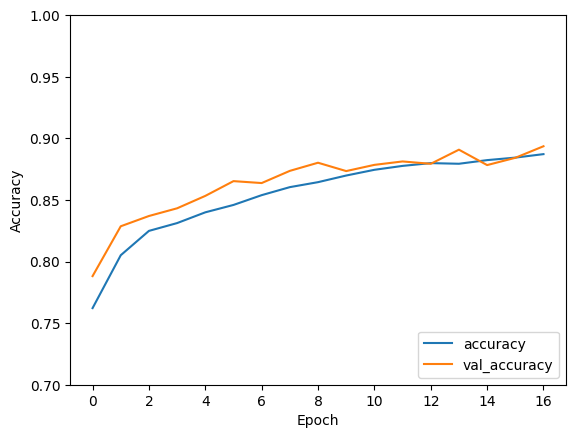

109/109 [==============================] - 1s 3ms/step


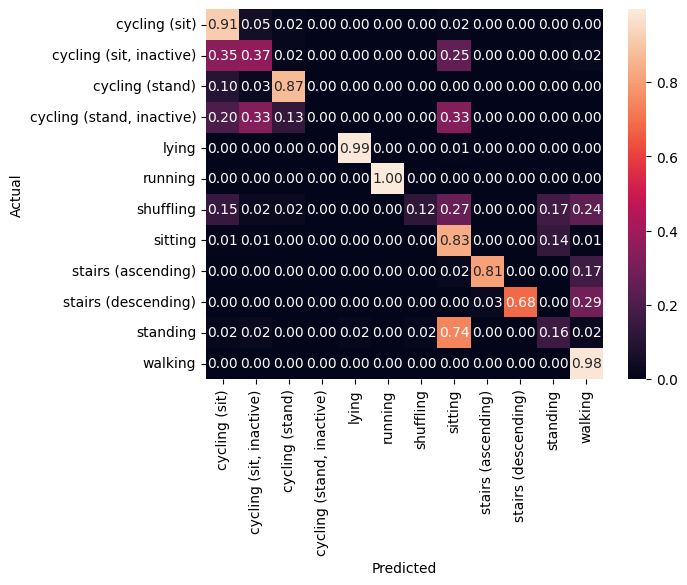

In [10]:
import matplotlib.pyplot as plt
plt.plot(CNNLSTM_history.history['categorical_accuracy'], label='accuracy')
plt.plot(CNNLSTM_history.history['val_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.7, 1])
plt.legend(loc='lower right')
plt.show()

lstm_test_result = full_CNNLSTM_model.evaluate(user_datasets_processed[2][0],  user_datasets_processed[2][1], return_dict=True)
predicted_labels = np.argmax(full_CNNLSTM_model.predict(user_datasets_processed[2][0]), axis=1)
true_labels = np.argmax(user_datasets_processed[2][1], axis=1)
confusion_mat = tf.math.confusion_matrix(true_labels, predicted_labels)
cm = confusion_mat.numpy()
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)